In [1]:
from PIL import Image, ImageOps
from numpy import array, asarray

image_matrix = []
image_test_matrix = []

for i in range(1000):
    im = Image.open("3dshapes_test/" + str(i) + ".jpg")
    gray_image = ImageOps.grayscale(im)

    g_array = array(gray_image)
    fg = g_array.flatten()
    fg = fg.reshape(1, 4096)

    image_test_matrix.append(fg[0])

image_test_matrix = asarray(image_test_matrix,dtype='float64')

for j in range(10000):

    im = Image.open("3dshapes_train/" + str(j) + ".jpg")
    gray_image = ImageOps.grayscale(im)

    g_array = array(gray_image)
    fg = g_array.flatten()
    fg = fg.reshape(1, 4096)

    image_matrix.append(fg[0])

# image_matrix is the desired matrix of size 10000x4096 PART A
image_matrix = asarray(image_matrix,dtype='float64')

# features from first phase

In [2]:
from sklearn.decomposition import PCA
# n_components can change according to desired feature number
pca=PCA(n_components=50)
pca.fit(image_matrix)
image_matrix_reducted = pca.transform(image_matrix)
test_values_reducted = pca.transform(image_test_matrix)

In [3]:
X = image_matrix_reducted
X_test = test_values_reducted

In [4]:
import numpy as np, pandas as pd
yvalues = np.load('orientations_train.npy')
y_testvalues = np.load('orientations_test.npy')
unique_list_y = list(set(yvalues))
unique_list_y_test = list(set(y_testvalues))
encoded_yvalues = np.array([unique_list_y.index(i) for i in yvalues])
encoded_y_testvalues = np.array([unique_list_y_test.index(i) for i in y_testvalues])
y_train = np.array(pd.get_dummies(encoded_yvalues).values, dtype=np.float64)
y_test = np.array(pd.get_dummies(encoded_y_testvalues).values, dtype=np.float64)

## 1.a applying TSNE to feature reducted images

/Users/veyisT/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


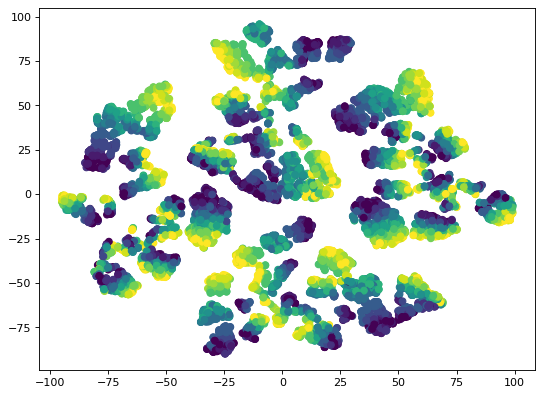

In [5]:

import matplotlib.pyplot as plt, numpy as np, pandas as pd
from sklearn.manifold import TSNE

#X_embedded = pd.DataFrame(TSNE(n_components=2,init='random').fit_transform(image_matrix))
X_embedded_reducted = pd.DataFrame(TSNE(n_components=2,init='random').fit_transform(X))

plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(X_embedded_reducted[0], X_embedded_reducted[1], c=yvalues)
plt.show()
#18 seconds

## 1.b gradient of the loss function

$$loss = f(W) =  \frac{1}{N}  \sum_{i=1}^{N}  (X_{i}W_{Y_{i}=k} + log \sum_{k=0}^{C} e^{-X_{i}W_{k}})$$
$$\nabla _{W_{k}}f(W)  = \frac{1}{N}   \sum_{i=1}^{N}  (X_{i}^{T}I_{[Y_{i}=k]} - X_{i}^{T}  \frac{e^{-X_{i}W_{k}}}{ \sum_{k=0}^{C} e^{-X_{i}W_{k}} }   )$$
$$\nabla _{W_{k}}f(W)  = \frac{1}{N}   \sum_{i=1}^{N}  (X_{i}^{T}I_{[Y_{i}=k]} - X_{i}^{T}  S_{i}  )$$
$$\nabla _{W_{k}}f(W)  = \frac{1}{N}  (   \sum_{i=1}^{N} X_{i}^{T}I_{[Y_{i}=k]} -  \sum_{i=1}^{N}  X_{i}^{T}  S_{i}  )$$
$$\nabla _{W_{k}}f(W)  = \frac{1}{N}  (   X^{T}Y_{One Hot Encoded} -  X^{T}  S  )$$
$$\nabla _{W_{k}}f(W)  = \frac{1}{N}  (   X^{T} (Y_{One Hot Encoded} -  S))$$

## 1.c determine step size of full batch using 5-fold

In [6]:
def softmax(x):
    """
    since x is matrix, we should calculate softwax rowwise
    """
    new_matrix = []
    for row in x:
        part_1 = np.exp(row)
        part_2 = np.sum(part_1)
        new_matrix.append(part_1 / part_2)
    return np.array(new_matrix)

def loss_function(X, Y, W):# Y is onehot encoded 
    Z = - np.dot(X,W)
    part_1 = np.trace(np.dot((-Z), Y.transpose())) 
    part_2 = np.sum(np.log(np.sum(np.exp(Z), axis=1)))
    loss = 1/len(X) *(part_1+part_2)
    #loss = 1/len(X) * (np.trace(np.dot((-Z), Y.transpose())) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def gradient(X, Y, W, reg_param=0,is_l1=None, learning_rate=0): # Y is onehot encoded 
    X_W = - np.dot(X,W)
    # we found the formula of the gradient in prev part
    if is_l1: 
        W[abs(W) < abs(learning_rate*reg_param)] = 0
        #W = np.sign(W)
    gradient = 1/len(X) * np.dot(X.transpose(),(Y - softmax(X_W))) + 2 * reg_param * W
    return gradient

In [7]:
def gradient_descent(X, Y, threshold=0.001, regularization_param=None,is_l1=None):
    l_r=0.1
    W = np.zeros((X.shape[1], Y.shape[1]))
    step = 0
    loss_list = []
    W_list = []
    step = 1
    if regularization_param:
        W -= l_r * gradient(X, Y, W, regularization_param,is_l1=is_l1, learning_rate=l_r)
    else:
        W -= l_r * gradient(X, Y, W,is_l1=is_l1)
        
    loss_list = [loss_function(X, Y, W)]
    W_list = [W]
    
    while 1:
        step += 1
        if regularization_param:
            W -= l_r * gradient(X, Y, W, regularization_param,is_l1=is_l1, learning_rate=l_r)
        else:
            W -= l_r * gradient(X, Y, W,is_l1=is_l1)
     
        W_list.append(W)
        loss_list.append(loss_function(X, Y, W))
        if abs(loss_list[-2] - loss_list[-1]) < threshold:
            break
    return loss_list, W


def predict(X_test,W):
    Z = - np.dot(X_test, W)
    S = softmax(Z)
    return np.argmax(S, axis=1)

In [8]:
### fold the data
data_size = len(X)
k_fold_datasets = {}
for i in range(5):
    x_train_part = np.vstack([X[:i*data_size//5,:],  X[(i+1)*data_size//5:,:]])
    x_test_part = X[i*data_size//5 : (i+1)*data_size//5,:]
    y_train_part = np.vstack([y_train[:i*data_size//5,:],  y_train[(i+1)*data_size//5:,:]])
    y_test_part = y_train[i*data_size//5 : (i+1)*data_size//5,:]
    k_fold_datasets[i] = (x_train_part,x_test_part,y_train_part,y_test_part)


In [9]:
#  train
loss_and_w_values_of_k_fold = []
for xtrain,xval,ytrain,yval in k_fold_datasets.values():
    norm = np.linalg.norm(xtrain)/1000
    normal_array = xtrain/norm
    loss_steps, W = gradient_descent(normal_array, ytrain)
    loss_and_w_values_of_k_fold.append((loss_steps, W))
# 5m 9s

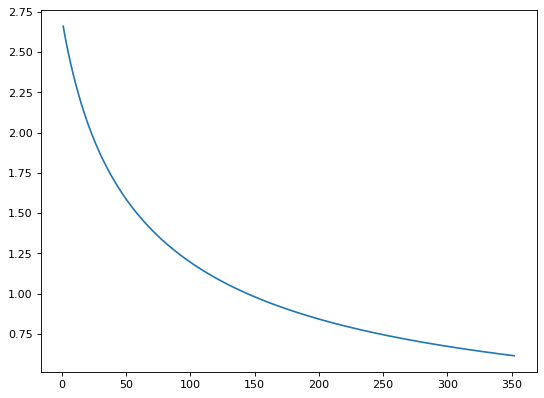

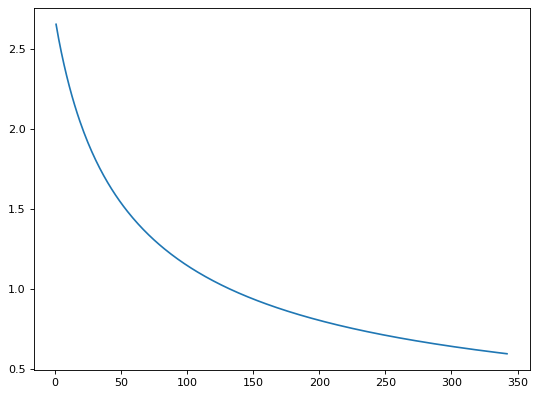

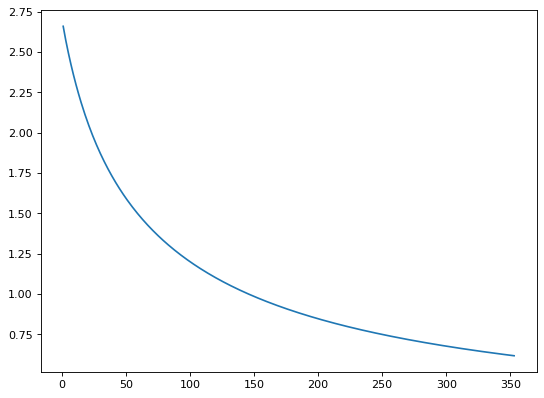

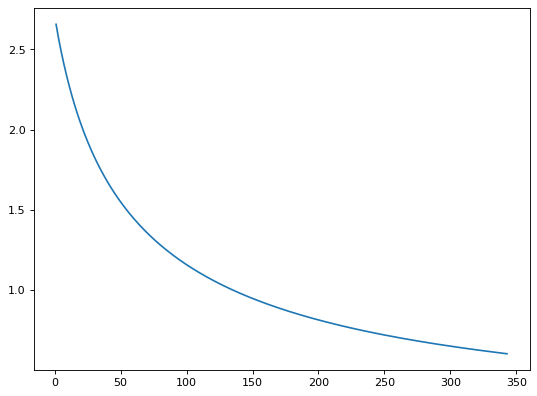

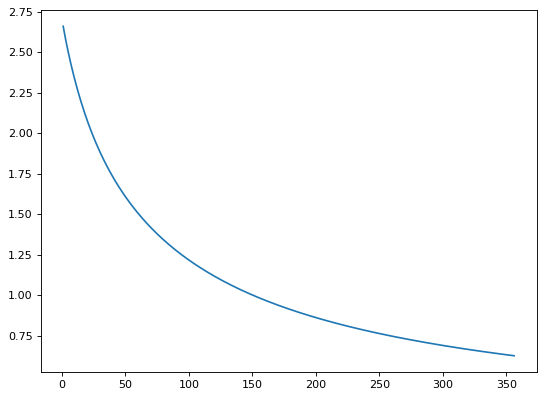

In [10]:
# plot loss
for loss_steps,_ in loss_and_w_values_of_k_fold:
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(range(1,len(loss_steps)+1),loss_steps)
    #plt.legend(handles=scatter.legend_elements()[0])
    plt.show()

In [11]:
print("Step sizes of folds:",[len (x) for (x,_) in loss_and_w_values_of_k_fold]) # [352, 342, 352, 343, 356]
print("Average step size:",sum([len (x) for (x,_) in loss_and_w_values_of_k_fold])//5) # 349

Step sizes of folds: [352, 342, 353, 343, 356]
Average step size: 349


## 1.d the training and test classification accuracy

#### predict

In [12]:
# predict  validation
training_accuracies = []
for (xtrain,xval,ytrain,yval),(_,W_of_fold) in zip(k_fold_datasets.values(),loss_and_w_values_of_k_fold):
    norm = np.linalg.norm(xval)/1000
    normal_array = xval/norm
    predicts  = predict(normal_array,W_of_fold)
    actual = np.argmax(yval,axis=1)
    training_accuracies.append(np.sum((predicts == actual) == True)/ len(predicts))


In [13]:
print("Training accuracies of folds:",training_accuracies) # [0.9605, 0.946, 0.9515, 0.9325, 0.943]
print("Average training accuracy:", sum(training_accuracies)/len(training_accuracies)) # 0.9466999999999999

Training accuracies of folds: [0.961, 0.9435, 0.951, 0.934, 0.9415]
Average training accuracy: 0.9461999999999999


### surely there is an overfit, average accuracy is .94

In [14]:
# predict testset
test_accuracies = []
for (_,W_of_fold) in loss_and_w_values_of_k_fold:
    norm = np.linalg.norm(test_values_reducted)/1000
    normal_array = test_values_reducted/norm
    predicts = predict(normal_array,W_of_fold)
    actual = np.argmax(y_test,axis=1)
    test_accuracies.append(np.sum((predicts == actual) == True)/ len(predicts))


In [15]:
test_accuracies # [0.965, 0.958, 0.957, 0.95, 0.953]

[0.965, 0.958, 0.957, 0.95, 0.953]

## 1.e using L2 regularization

In [16]:
#  train with L2 regularization
loss_and_w_values_of_k_fold_with_l2 = []
reg_params = [0.1,0.01,0.001,0.0001,0.00001]
for i in range(5):
    xtrain,xval,ytrain,yval = k_fold_datasets[i]
    norm = np.linalg.norm(xtrain)/1000
    normal_array = xtrain/norm
    loss_steps, W = gradient_descent(normal_array, ytrain,regularization_param=reg_params[i])
    loss_and_w_values_of_k_fold_with_l2.append((loss_steps, W))
# 4m 10s

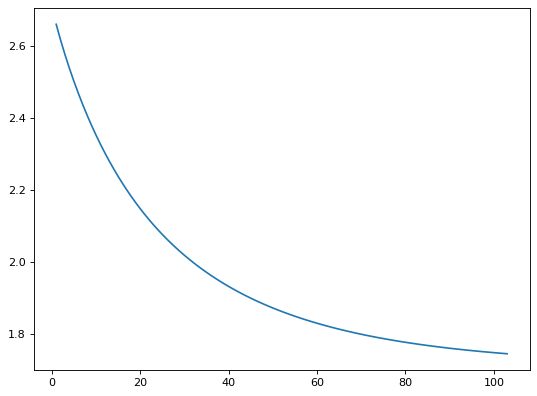

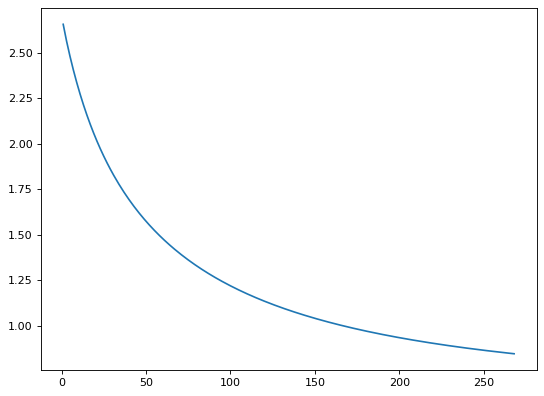

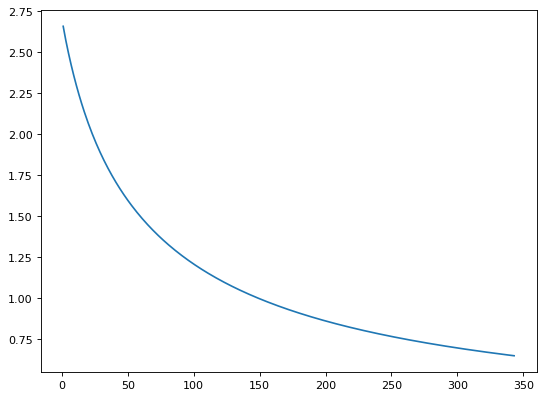

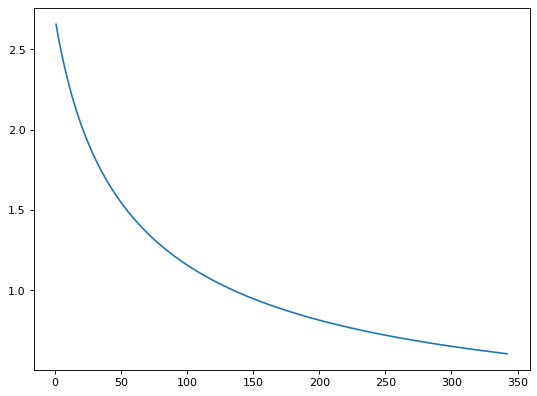

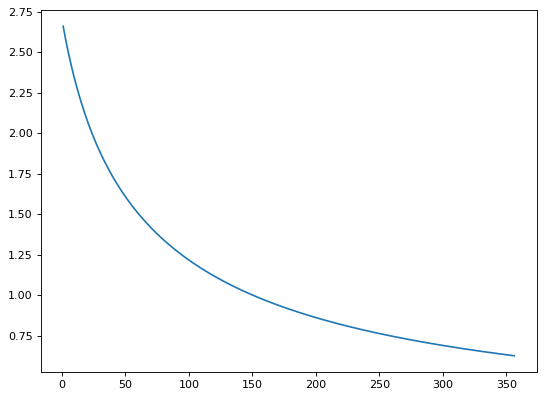

In [17]:
# plot loss l2
for loss_steps,_ in loss_and_w_values_of_k_fold_with_l2:
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(range(1,len(loss_steps)+1),loss_steps)
    #plt.legend(handles=scatter.legend_elements()[0])
    plt.show()

In [18]:
# predict validation l2
training_accuracies_with_l2 = []
for (xtrain,xval,ytrain,yval),(_,W_of_fold) in zip(k_fold_datasets.values(),loss_and_w_values_of_k_fold_with_l2):
    norm = np.linalg.norm(xval)/1000
    normal_array = xval/norm
    predicts  = predict(normal_array,W_of_fold)
    actual = np.argmax(yval,axis=1)
    training_accuracies_with_l2.append(np.sum((predicts == actual) == True)/ len(predicts))


In [19]:
print("Training accuracies of folds with L2:",training_accuracies_with_l2) # [0.8535, 0.9215, 0.949, 0.9325, 0.9415]
print("Average training accuracy with L2:", sum(training_accuracies_with_l2)/len(training_accuracies_with_l2)) # 0.9196

Training accuracies of folds with L2: [0.8535, 0.9215, 0.949, 0.9325, 0.9415]
Average training accuracy with L2: 0.9196


In [20]:
# predict testset l2
test_accuracies_with_l2 = []
for (_,W_of_fold) in loss_and_w_values_of_k_fold_with_l2:
    norm = np.linalg.norm(test_values_reducted)/1000
    normal_array = test_values_reducted/norm
    predicts = predict(normal_array,W_of_fold)
    actual = np.argmax(y_test,axis=1)
    test_accuracies_with_l2.append(np.sum((predicts == actual) == True)/ len(predicts))

In [21]:
test_accuracies_with_l2 # [0.838, 0.936, 0.949, 0.95, 0.953]

[0.838, 0.936, 0.949, 0.95, 0.953]

Best accuracy is when regularization param is 0.00001. But that's infeasible, because it is too slow. We have a great performance even when regularization param is 0.01. 

## 1.f we did not observe underfitting

## 1.g investigate the weight values and their corresponding features

In [22]:
# we take the W of the last classifier.
final_W = loss_and_w_values_of_k_fold[0][1] # first fold has the highest accuracy
#print(np.array_str(final_W, precision=1, suppress_small=True))
import pandas
pd.DataFrame(final_W).to_csv("./weights.csv",float_format='%.3f')

In [23]:
# we take the W of the last classifier with L2 regularization.
final_W = loss_and_w_values_of_k_fold_with_l2[2][1] # second fold has the highest accuracy
#print(np.array_str(final_W, precision=1, suppress_small=True))
import pandas
pd.DataFrame(final_W).to_csv("./l2_weights.csv",float_format='%.3f')

After investigating csv values obtained form previous cells, 
* Original weight matrix has much more higher values than other matrices. We think the reason is overfit.
* Maximum values of all the matrices have same index: (3,3), (3,5), (3,10), (3,12), (11,6), (11,9). 3rd and 11th features of the training set influences predicitons much more.
* To give a concrete example, 11th feature influences most for the probability of making prediction 6 since it has the highest weight in 6th column.
You can investigate final weight matrices from csv files which are generated in previous cells.

## 1.h logistic regression with L1-norm regularization

In [24]:
#  train with L1 regularization
loss_and_w_values_of_k_fold_with_l1 = []
reg_params = [0.1,0.01,0.001,0.0001,0.00001]
for i in range(5):
    xtrain,xval,ytrain,yval = k_fold_datasets[i]
    norm = np.linalg.norm(xtrain)/1000
    normal_array = xtrain/norm
    loss_steps, W = gradient_descent(normal_array, ytrain,regularization_param=reg_params[i],is_l1=True)
    loss_and_w_values_of_k_fold_with_l1.append((loss_steps, W))
# 4m 12s

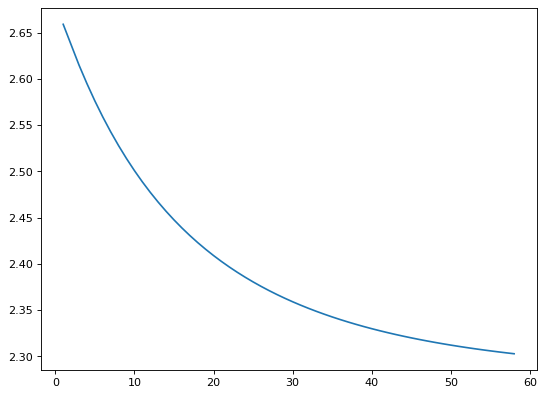

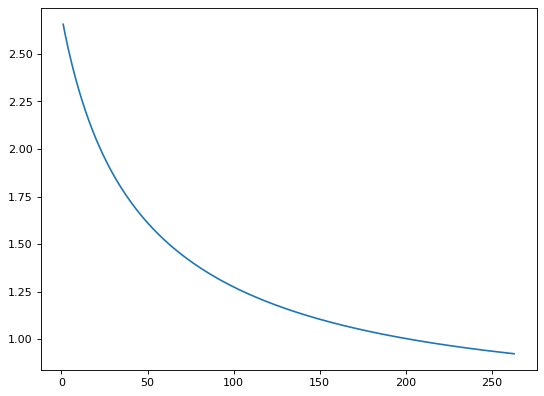

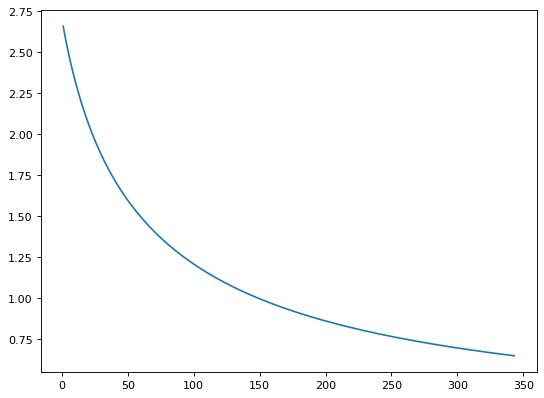

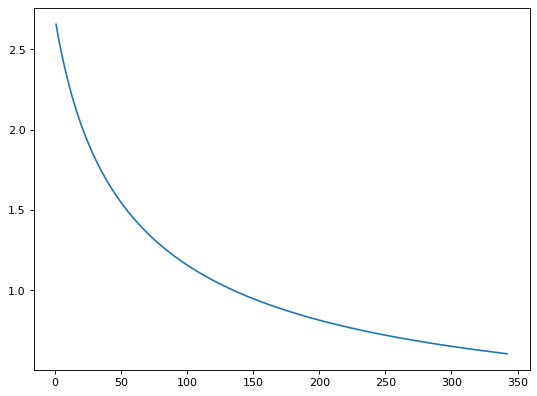

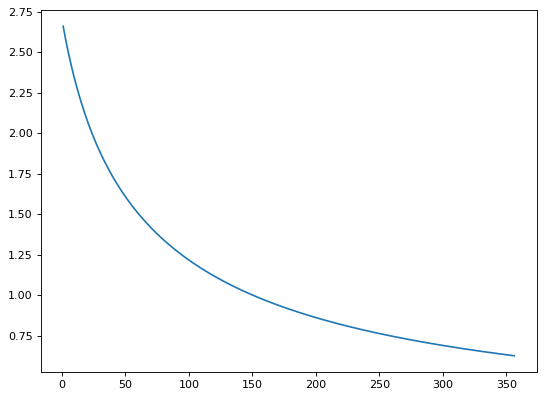

In [25]:
# plot loss l1
for loss_steps,_ in loss_and_w_values_of_k_fold_with_l1:
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(range(1,len(loss_steps)+1),loss_steps)
    #plt.legend(handles=scatter.legend_elements()[0])
    plt.show()

In [26]:
# predict validation l1
training_accuracies_with_l1 = []
for (xtrain,xval,ytrain,yval),(_,W_of_fold) in zip(k_fold_datasets.values(),loss_and_w_values_of_k_fold_with_l1):
    norm = np.linalg.norm(xval)/1000
    normal_array = xval/norm
    predicts  = predict(normal_array,W_of_fold)
    actual = np.argmax(yval,axis=1)
    training_accuracies_with_l1.append(np.sum((predicts == actual) == True)/ len(predicts))

In [27]:
print("Training accuracies of folds with L1:",training_accuracies_with_l1) # [0.1625, 0.877, 0.949, 0.9325, 0.9415]
print("Average training accuracy with L1:", sum(training_accuracies_with_l1)/len(training_accuracies_with_l1)) # 0.7725000000000001

Training accuracies of folds with L1: [0.1625, 0.877, 0.949, 0.9325, 0.9415]
Average training accuracy with L1: 0.7725000000000001


In [28]:
# predict testset l1
test_accuracies_with_l1 = []
for (_,W_of_fold) in loss_and_w_values_of_k_fold_with_l1:
    norm = np.linalg.norm(test_values_reducted)/1000
    normal_array = test_values_reducted/norm
    predicts = predict(normal_array,W_of_fold)
    actual = np.argmax(y_test,axis=1)
    test_accuracies_with_l1.append(np.sum((predicts == actual) == True)/ len(predicts))

In [29]:
test_accuracies_with_l1 # [0.169, 0.901, 0.95, 0.95, 0.953]

[0.169, 0.901, 0.95, 0.95, 0.953]

In [30]:
# we take the W of the last classifier with L1 regularization.
final_W = loss_and_w_values_of_k_fold_with_l1[2][1]# second fold has the highest accuracy
#print(np.array_str(final_W, precision=1, suppress_small=True))
import pandas
pd.DataFrame(final_W).to_csv("./l1_weights.csv",float_format='%.3f')

After investigating csv values obtained form previous cells, 
* L1 regularization weight matrix has lofts of 0 entries, it's sparse. Some rows have all 0's which means those features have no influence on predictions.
* Results are consistent with other weight matrices. 


# 2. Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X, encoded_yvalues)
y_pred = classifier.predict(X_test)

count = 0

for i in range(len(y_pred)):
    if encoded_y_testvalues[i] != y_pred[i]:
        count = count + 1

percentage = float(100 - float((count / X_test.shape[0]) * 100))/100
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], count)) # 51
print("Test classification accuracy: %.2f" % percentage) # 0.95

Number of mislabeled points out of a total 1000 points : 51
Test classification accuracy: 0.95


Accuracy is almost same with logistic regresison without regularization. We would go for Naive Bayes since it's much faster.

## 2.b Whether conditional independence assumption hold for the features we used in this phase

Like other supervised models, naive bayes uses features to come up with predictions on a specific target variable. The prominent difference is that it adapts the conditional independence assumption into its calculative procedure. According to this assumption there is no correlation between features. This is usually not a practical assumption as from many data sets, at least some of the extracted features are somewhat related to one another. Therefore, the result which is obtained from naive base classifier approach usually worse than the other classifiers even though it is faster. However, in our case we obtain a score of 0.95 when we implemented Gaussian Naive Bayes algorithm. This result tells us that our features are in fact shows high independence from each other. Reducing the features by PCA mostly caused the probable connective features to be decreased or eliminated. Remaining features then sustained the independence.

## 2.c number of parameters

In [33]:
import math
# with assumption formula: 15*d*(k-1)
# without assumption formula: 15*(k^d-1)
# d is 50
# k is 2 since input is continous and we only need to estimate 2 parameters: mean and variance of gaussian distribution
with_assumption = 15*50*(2-1) # 750
without_assumption = 15*(math.pow(2,50-1)) # 8444249301319680
print("with assumption:",with_assumption)
print("without assumption:",without_assumption)


with assumption: 750
without assumption: 8444249301319680.0


References: 
* https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* https://towardsdatascience.com/multiclass-logistic-regression-from-scratch-9cc0007da372
* https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261#1d17
* https://peterroelants.github.io/posts/cross-entropy-softmax/